<a href="https://colab.research.google.com/github/joshuamach632-hub/TB-model/blob/main/GRADCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/TB_Model/tb_cnn_model.h5')

In [3]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,795,908 (182.33 MB)

 Trainable params: 47,795,906 (182.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [4]:
for layer in model.layers:
    print(layer.name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
flatten
dense
dense_1


In [5]:
#Dependencies

import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as PLT
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [6]:
!pip install kaggle

In [7]:
kaggle_credentials = json.load(open("kaggle.json"))

In [8]:
#setup Kaggle API key as environment variables
os.environ['KAGGLE USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE KEY'] = kaggle_credentials["key"]

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tuberculosis-tb-chest-xray-dataset


In [10]:
!cp -r /kaggle/input/tuberculosis-tb-chest-xray-dataset /content/

In [12]:
!ls /content/tuberculosis-tb-chest-xray-dataset

TB_Chest_Radiography_Database


In [13]:
last_conv_layer_name = 'conv2d_1'

In [14]:
#GRAD CAM FUNCTION
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Call the model once to define its output shape
    _ = model(img_array)

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [15]:
# Set up ImageDataGenerator for training data
train_datagen = ImageDataGenerator(rescale=1./255) # Add other augmentations here if needed

# Create the train_generator
train_generator = train_datagen.flow_from_directory(
    '/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/', # Path to your training data
    target_size=(224, 224), # Set this to the input size of your model
    batch_size=32,
    class_mode='categorical' # Or 'binary' depending on your model's output layer
)

Found 4200 images belonging to 2 classes.


In [16]:
#function to load and preprocess image using pillow

def load_and_preprocess_image(image_path, target_size=(224, 224)):

  #load image
  from PIL import Image
  img= Image.open(image_path)

  #Convert to RGB using PIL
  img = Image.open(image_path).convert('RGB')

  #Resize image
  img= img.resize(target_size)

  #Convert image into numpy array

  img_array= np.array(img)

  #add batch dimension
  img_array= np.expand_dims(img_array, axis=0)

  #scale image values to 0,1

  img_array= img_array.astype('float32')/255.
  return img_array

In [17]:
#function to predict class of an image

def predict_image_class(model, image_path, class_indices):

 preprocessed_img = load_and_preprocess_image(image_path)
 predictions = model.predict(preprocessed_img)
 predicted_class_index= np.argmax(predictions, axis=1) [0]
 predicted_class_name = class_indices[predicted_class_index]
 return predicted_class_name

In [18]:
#creating a napping from class indices to class names
class_indices={v:k for k, v in train_generator.class_indices.items()}

In [19]:
#saving the class names as a json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [21]:
#Example
#image_path="/content/76052f7902246ff862f52f5d3cd9cd_big_gallery.jpg"
#image_path="/content/pulmonary-tuberculosis-29.jpg"
#image_path="/content/pulmonary-tuberculosis-67.png"
image_path="/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-10.png"
predicted_class_name = predict_image_class(model, image_path,class_indices)

#output the result

print( "X-ray detected:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
X-ray detected: Tuberculosis


In [22]:
#Load and preprocess image

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Load image
img_path = "/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-1.png"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

#activate model
_ = model.predict(img_array)  # or model(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [25]:
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_1')

# Convert heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Load original image again (in case it's needed for overlay)
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (512, 512))

# Superimpose
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

# Save or display
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Grad-CAM')
plt.show()

AttributeError: The layer sequential has never been called and thus has no defined output.

In [ ]:
#heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_1')

# Convert heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Load original image again (in case it's needed for overlay)
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (224, 224)) # Resize original image to match heatmap size

# Superimpose
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

# Save or display
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Grad-CAM')
plt.show()

/tmp/ipython-input-2424307836.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


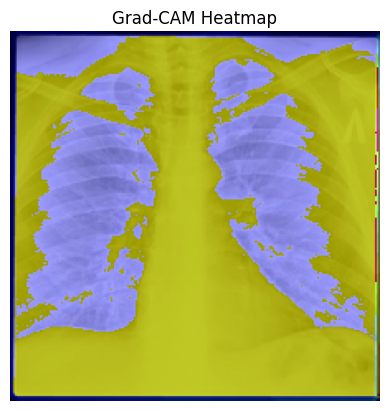

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

# -------------------------------
# Grad-CAM Function
# -------------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Define a placeholder input with the expected shape
    input_layer = tf.keras.Input(shape=img_array.shape[1:])

    # Build intermediate model to get conv layer output
    x = input_layer
    for layer in model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            last_conv_layer_output = x
            break
    intermediate_model = tf.keras.models.Model(inputs=input_layer, outputs=last_conv_layer_output)

    # Build classification model from the output of the last conv layer
    x = last_conv_layer_output
    for layer in model.layers[model.layers.index(model.get_layer(last_conv_layer_name)) + 1:]:
        x = layer(x)
    classification_model = tf.keras.models.Model(inputs=last_conv_layer_output, outputs=x)


    with tf.GradientTape() as tape:
        conv_outputs = intermediate_model(img_array)
        predictions = classification_model(conv_outputs) # Pass conv_outputs to the classification model
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# -------------------------------
# Preprocess Image
# -------------------------------
image_path="/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-10.png"
# Resize the image to the model's expected input size (224x224)
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# 🔑 Run model once to initialize layers
# This line is still necessary to build the model completely before accessing model.input and model.output
# Or rather, ensures the model is called at least once
_ = model(img_array)


# -------------------------------
# Generate Grad-CAM Heatmap
# -------------------------------
heatmap = make_gradcam_heatmap(img_array, model, "conv2d_1")

# -------------------------------
# Overlay Heatmap on Original Image
# -------------------------------
# Resize heatmap to the size of the original image for better visualization
original_img = cv2.imread(image_path)
original_img = cv2.resize(original_img, (224, 224)) # Resize original image for overlay

heatmap = cv2.resize(heatmap, (224, 224)) # Resize heatmap to match the original image size
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((224, 224))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img_array[0] * 255.0 # Multiply by 255 for correct overlay
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img.astype(np.uint8)) # Convert to uint8

plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM Heatmap")
plt.show()